In [ ]:
# Import required libraries
%pip install seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Create sample loan dataset
def create_sample_dataset(n_samples=1000):
    """Create a realistic loan dataset for demonstration"""
    np.random.seed(42)
    
    data = {
        'Gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.6, 0.4]),
        'Married': np.random.choice(['Yes', 'No'], n_samples, p=[0.7, 0.3]),
        'Dependents': np.random.choice(['0', '1', '2', '3+'], n_samples, p=[0.4, 0.3, 0.2, 0.1]),
        'Education': np.random.choice(['Graduate', 'Not Graduate'], n_samples, p=[0.75, 0.25]),
        'Self_Employed': np.random.choice(['Yes', 'No'], n_samples, p=[0.15, 0.85]),
        'ApplicantIncome': np.random.normal(5000, 2000, n_samples).astype(int),
        'CoapplicantIncome': np.random.exponential(1500, n_samples).astype(int),
        'LoanAmount': np.random.normal(150, 50, n_samples).astype(int),
        'Loan_Amount_Term': np.random.choice([360, 240, 180, 120], n_samples, p=[0.8, 0.1, 0.05, 0.05]),
        'Credit_History': np.random.choice([1.0, 0.0], n_samples, p=[0.85, 0.15]),
        'Property_Area': np.random.choice(['Urban', 'Semiurban', 'Rural'], n_samples, p=[0.4, 0.35, 0.25])
    }
    
    # Create target variable based on logical rules
    loan_status = []
    for i in range(n_samples):
        score = 0
        
        # Income factor
        total_income = data['ApplicantIncome'][i] + data['CoapplicantIncome'][i]
        if total_income > 8000:
            score += 3
        elif total_income > 5000:
            score += 2
        elif total_income > 3000:
            score += 1
        
        # Credit history (most important factor)
        if data['Credit_History'][i] == 1.0:
            score += 4
        
        # Education
        if data['Education'][i] == 'Graduate':
            score += 1
        
        # Property area
        if data['Property_Area'][i] == 'Urban':
            score += 1
        
        # Loan amount to income ratio
        if data['LoanAmount'][i] * 1000 / total_income < 3:
            score += 2
        elif data['LoanAmount'][i] * 1000 / total_income < 5:
            score += 1
        
        # Marriage status
        if data['Married'][i] == 'Yes':
            score += 1
        
        # Add some randomness
        score += np.random.normal(0, 1)
        
        # Convert score to binary decision
        loan_status.append('Y' if score > 5 else 'N')
    
    data['Loan_Status'] = loan_status
    
    # Introduce some missing values
    df = pd.DataFrame(data)
    missing_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
    df.loc[missing_indices[:len(missing_indices)//3], 'Gender'] = np.nan
    df.loc[missing_indices[len(missing_indices)//3:2*len(missing_indices)//3], 'LoanAmount'] = np.nan
    df.loc[missing_indices[2*len(missing_indices)//3:], 'Credit_History'] = np.nan
    
    return df

# Load or create dataset
print("Creating sample loan dataset...")
df = create_sample_dataset(1000)
print(f"Dataset created with {len(df)} records")
print("\nDataset Info:")
print(df.info())

  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- --------------------------

First 5 rows of the dataset:
   Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0    Male     Yes          0      Graduate            No             3806   
1  Female     Yes          0  Not Graduate            No              219   
2  Female      No         3+      Graduate            No             4175   
3    Male      No          0      Graduate            No             6826   
4    Male      No          0      Graduate           Yes             6075   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                101       142.0               360             1.0   
1               1195       152.0               360             1.0   
2               1340       201.0               360             1.0   
3               1586       140.0               360             1.0   
4                442       121.0               360             1.0   

  Property_Area Loan_Status  
0     Semiurban           Y  
1     Semiurban           Y

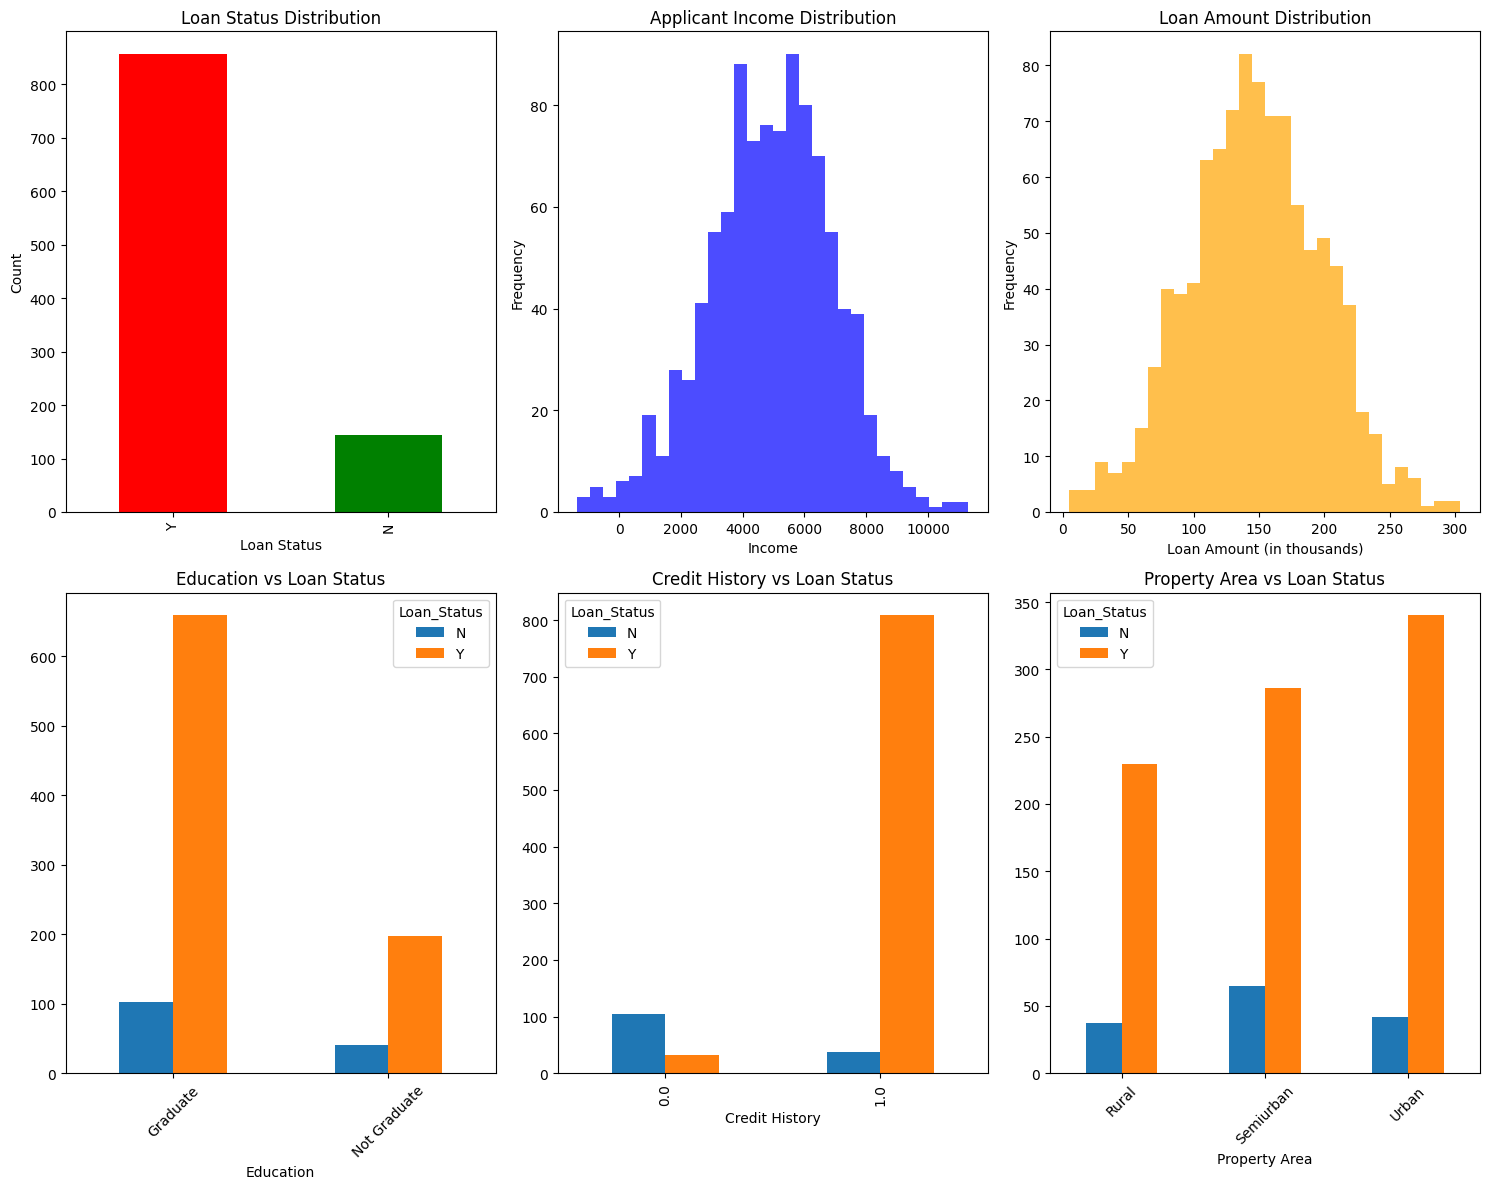

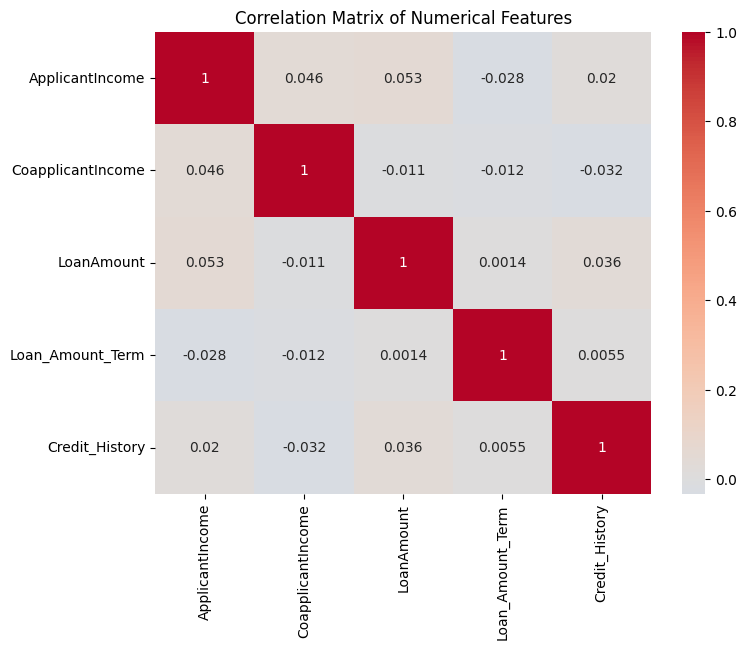

In [4]:
# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget variable distribution:")
print(df['Loan_Status'].value_counts())
print(f"Approval rate: {df['Loan_Status'].value_counts()['Y'] / len(df) * 100:.2f}%")

# Statistical summary
print("\nNumerical features summary:")
print(df.describe())

# Visualizations
plt.figure(figsize=(15, 12))

# Target distribution
plt.subplot(2, 3, 1)
df['Loan_Status'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Income distribution
plt.subplot(2, 3, 2)
plt.hist(df['ApplicantIncome'], bins=30, alpha=0.7, color='blue')
plt.title('Applicant Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')

# Loan amount distribution
plt.subplot(2, 3, 3)
plt.hist(df['LoanAmount'].dropna(), bins=30, alpha=0.7, color='orange')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount (in thousands)')
plt.ylabel('Frequency')

# Education vs Loan Status
plt.subplot(2, 3, 4)
education_loan = pd.crosstab(df['Education'], df['Loan_Status'])
education_loan.plot(kind='bar', ax=plt.gca())
plt.title('Education vs Loan Status')
plt.xlabel('Education')
plt.xticks(rotation=45)

# Credit History vs Loan Status
plt.subplot(2, 3, 5)
credit_loan = pd.crosstab(df['Credit_History'], df['Loan_Status'])
credit_loan.plot(kind='bar', ax=plt.gca())
plt.title('Credit History vs Loan Status')
plt.xlabel('Credit History')

# Property Area vs Loan Status
plt.subplot(2, 3, 6)
property_loan = pd.crosstab(df['Property_Area'], df['Loan_Status'])
property_loan.plot(kind='bar', ax=plt.gca())
plt.title('Property Area vs Loan Status')
plt.xlabel('Property Area')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlation analysis for numerical features
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [6]:
# Create a copy for preprocessing
df_processed = df.copy()

print("Starting data preprocessing...")

# Handle missing values
print("\nHandling missing values...")

# For categorical variables, use mode
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for col in categorical_columns:
    if df_processed[col].isnull().sum() > 0:
        mode_value = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_value, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_value}")

# For numerical variables, use median
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
for col in numerical_columns:
    if df_processed[col].isnull().sum() > 0:
        median_value = df_processed[col].median()
        df_processed[col].fillna(median_value, inplace=True)
        print(f"Filled {col} missing values with median: {median_value}")

# For Credit_History, use mode (most common value)
if df_processed['Credit_History'].isnull().sum() > 0:
    mode_value = df_processed['Credit_History'].mode()[0]
    df_processed['Credit_History'].fillna(mode_value, inplace=True)
    print(f"Filled Credit_History missing values with mode: {mode_value}")

print(f"\nMissing values after preprocessing:\n{df_processed.isnull().sum()}")

# Feature engineering
print("\nPerforming feature engineering...")

# Create total income feature
df_processed['TotalIncome'] = df_processed['ApplicantIncome'] + df_processed['CoapplicantIncome']

# Create loan amount to income ratio
df_processed['LoanAmountToIncome'] = df_processed['LoanAmount'] / df_processed['TotalIncome']

# Create income per dependent
df_processed['Dependents_num'] = df_processed['Dependents'].replace('3+', '3').astype(int)
df_processed['IncomePerDependent'] = df_processed['TotalIncome'] / (df_processed['Dependents_num'] + 1)

# Log transformation for skewed features
df_processed['ApplicantIncome_log'] = np.log1p(df_processed['ApplicantIncome'])
df_processed['TotalIncome_log'] = np.log1p(df_processed['TotalIncome'])
df_processed['LoanAmount_log'] = np.log1p(df_processed['LoanAmount'])

print("New features created:")
print("- TotalIncome")
print("- LoanAmountToIncome")
print("- IncomePerDependent")
print("- Log-transformed income features")

# Encode categorical variables
print("\nEncoding categorical variables...")
label_encoders = {}
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

for feature in categorical_features:
    le = LabelEncoder()
    df_processed[feature + '_encoded'] = le.fit_transform(df_processed[feature])
    label_encoders[feature] = le
    print(f"Encoded {feature}")

# Prepare features and target
feature_columns = ['Gender_encoded', 'Married_encoded', 'Dependents_encoded', 'Education_encoded', 
                  'Self_Employed_encoded', 'Property_Area_encoded', 'ApplicantIncome', 'CoapplicantIncome',
                  'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 
                  'LoanAmountToIncome', 'IncomePerDependent', 'ApplicantIncome_log', 
                  'TotalIncome_log', 'LoanAmount_log']

X = df_processed[feature_columns]
y = df_processed['Loan_Status']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Target classes: {le_target.classes_}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Scale numerical features
scaler = StandardScaler()
numerical_indices = [X.columns.get_loc(col) for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
                                                       'TotalIncome', 'LoanAmountToIncome', 'IncomePerDependent',
                                                       'ApplicantIncome_log', 'TotalIncome_log', 'LoanAmount_log']]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled.iloc[:, numerical_indices] = scaler.fit_transform(X_train.iloc[:, numerical_indices])
X_test_scaled.iloc[:, numerical_indices] = scaler.transform(X_test.iloc[:, numerical_indices])

print("Feature scaling completed.")

Starting data preprocessing...

Handling missing values...
Filled Gender missing values with mode: Male
Filled LoanAmount missing values with median: 147.0
Filled Credit_History missing values with mode: 1.0

Missing values after preprocessing:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Performing feature engineering...
New features created:
- TotalIncome
- LoanAmountToIncome
- IncomePerDependent
- Log-transformed income features

Encoding categorical variables...
Encoded Gender
Encoded Married
Encoded Dependents
Encoded Education
Encoded Self_Employed
Encoded Property_Area

Feature matrix shape: (1000, 17)
Target vector shape: (1000,)
Target classes: ['N' 'Y']

Training set size: (800, 17)
Test set size: (200, 17)
Feature scaling completed.


In [9]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate models
model_results = {}
trained_models = {}

print("Training multiple machine learning models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for SVM and Logistic Regression
    if name in ['SVM', 'Logistic Regression']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Ensure no missing values in the training and testing data
    if X_train_model.isnull().sum().sum() > 0 or X_test_model.isnull().sum().sum() > 0:
        print("Missing values detected in training or testing data. Filling missing values with median...")
        X_train_model.fillna(X_train_model.median(), inplace=True)
        X_test_model.fillna(X_test_model.median(), inplace=True)    
    # Train the model
    model.fit(X_train_model, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='accuracy')
    
    model_results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print()

# Model comparison
print("Model Comparison Summary:")
print("-" * 60)
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'ROC-AUC': [results['roc_auc'] for results in model_results.values()],
    'CV Mean': [results['cv_mean'] for results in model_results.values()],
    'CV Std': [results['cv_std'] for results in model_results.values()]
})

print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model = trained_models[best_model_name]
print(f"\nBest performing model: {best_model_name}")

Training multiple machine learning models...

Training Logistic Regression...
Missing values detected in training or testing data. Filling missing values with median...
Logistic Regression Results:
  Accuracy: 0.9100
  ROC-AUC: 0.9526
  CV Score: 0.9275 (+/- 0.0150)

Training Random Forest...
Missing values detected in training or testing data. Filling missing values with median...
Random Forest Results:
  Accuracy: 0.9000
  ROC-AUC: 0.9229
  CV Score: 0.9225 (+/- 0.0437)

Training Gradient Boosting...
Gradient Boosting Results:
  Accuracy: 0.9200
  ROC-AUC: 0.9506
  CV Score: 0.9187 (+/- 0.0379)

Training SVM...
SVM Results:
  Accuracy: 0.8550
  ROC-AUC: 0.9476
  CV Score: 0.8562 (+/- 0.0000)

Model Comparison Summary:
------------------------------------------------------------
              Model  Accuracy  ROC-AUC  CV Mean   CV Std
Logistic Regression     0.910 0.952611  0.92750 0.007500
      Random Forest     0.900 0.922868  0.92250 0.021866
  Gradient Boosting     0.920 0.950595

Detailed Evaluation of Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

           N       0.74      0.69      0.71        29
           Y       0.95      0.96      0.95       171

    accuracy                           0.92       200
   macro avg       0.84      0.82      0.83       200
weighted avg       0.92      0.92      0.92       200



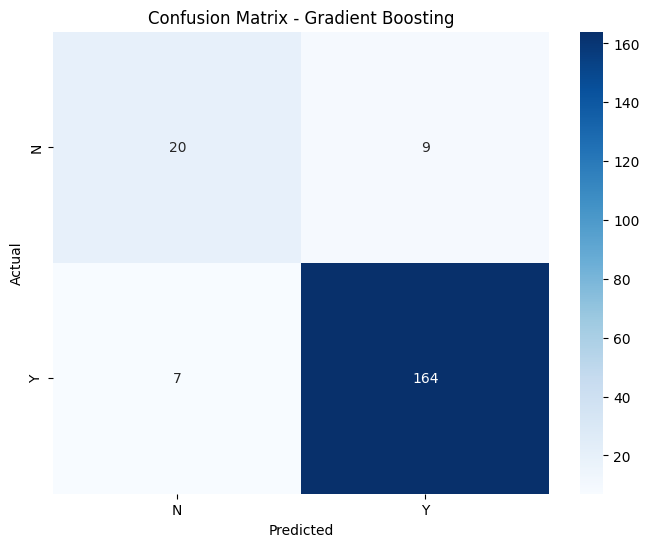

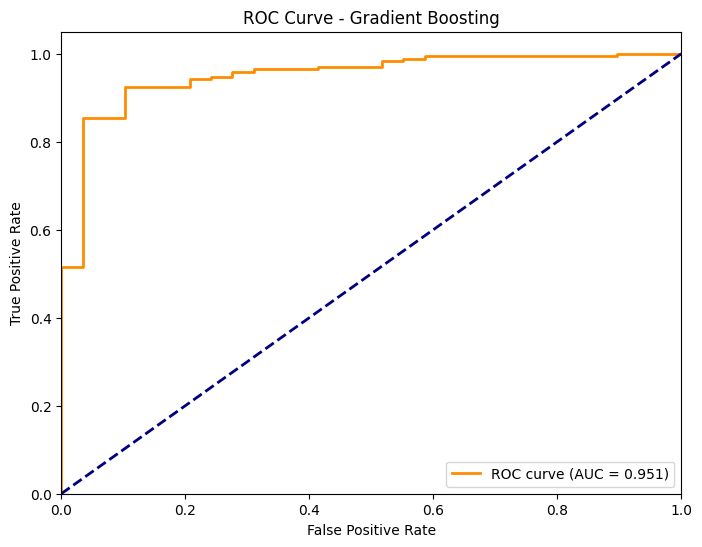

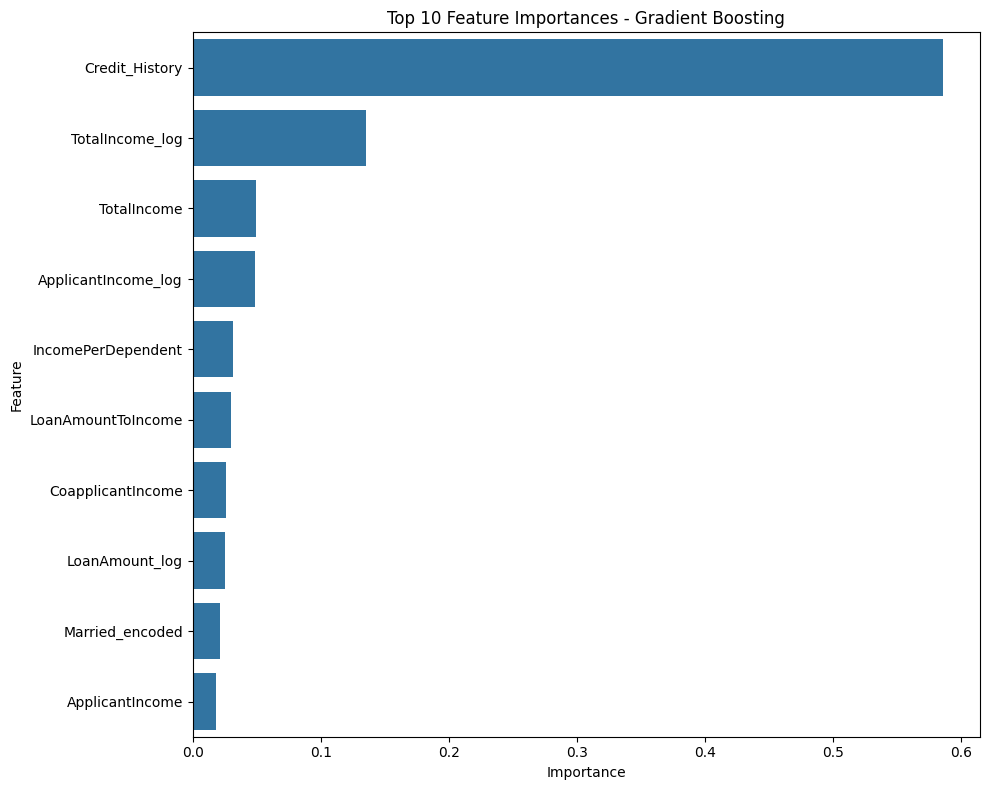


Top 10 Most Important Features:
            Feature  Importance
     Credit_History    0.585345
    TotalIncome_log    0.135097
        TotalIncome    0.049816
ApplicantIncome_log    0.048289
 IncomePerDependent    0.031385
 LoanAmountToIncome    0.029966
  CoapplicantIncome    0.025857
     LoanAmount_log    0.025185
    Married_encoded    0.021451
    ApplicantIncome    0.018211


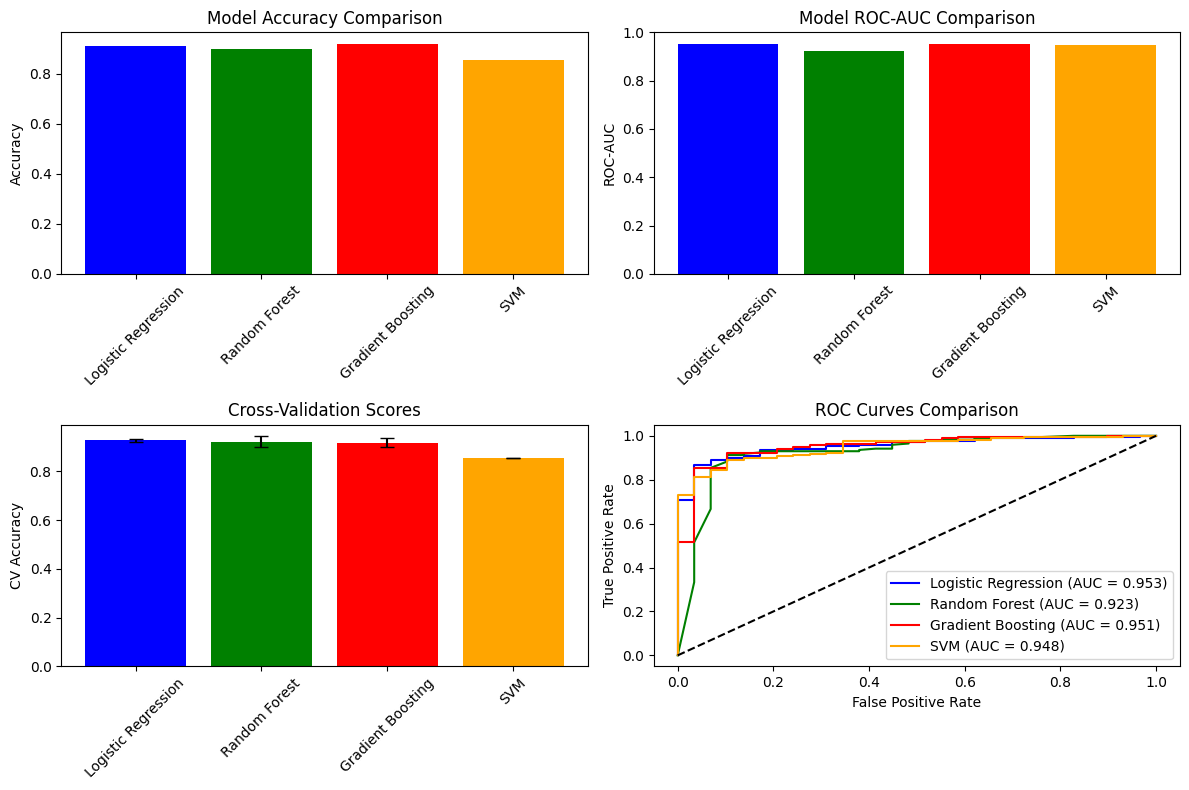

In [10]:
# Detailed evaluation of the best model
print(f"Detailed Evaluation of {best_model_name}")
print("=" * 50)

# Get predictions for best model
if best_model_name in ['SVM', 'Logistic Regression']:
    y_pred_best = best_model.predict(X_test_scaled)
    y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_best = best_model.predict(X_test)
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=le_target.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

# Model comparison visualization
plt.figure(figsize=(12, 8))

# Accuracy comparison
plt.subplot(2, 2, 1)
models_list = list(model_results.keys())
accuracies = [model_results[model]['accuracy'] for model in models_list]
plt.bar(models_list, accuracies, color=['blue', 'green', 'red', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# ROC-AUC comparison
plt.subplot(2, 2, 2)
roc_aucs = [model_results[model]['roc_auc'] for model in models_list]
plt.bar(models_list, roc_aucs, color=['blue', 'green', 'red', 'orange'])
plt.title('Model ROC-AUC Comparison')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)

# Cross-validation scores
plt.subplot(2, 2, 3)
cv_means = [model_results[model]['cv_mean'] for model in models_list]
cv_stds = [model_results[model]['cv_std'] for model in models_list]
plt.bar(models_list, cv_means, yerr=cv_stds, capsize=5, color=['blue', 'green', 'red', 'orange'])
plt.title('Cross-Validation Scores')
plt.ylabel('CV Accuracy')
plt.xticks(rotation=45)

# ROC curves for all models
plt.subplot(2, 2, 4)
colors = ['blue', 'green', 'red', 'orange']
for i, (name, results) in enumerate(model_results.items()):
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, color=colors[i], label=f'{name} (AUC = {results["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
class LoanEligibilityPredictor:
    def __init__(self, model, scaler, label_encoders, feature_columns, model_name):
        self.model = model
        self.scaler = scaler
        self.label_encoders = label_encoders
        self.feature_columns = feature_columns
        self.model_name = model_name
        self.numerical_indices = [feature_columns.index(col) for col in 
                                ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
                                 'TotalIncome', 'LoanAmountToIncome', 'IncomePerDependent',
                                 'ApplicantIncome_log', 'TotalIncome_log', 'LoanAmount_log']]
    
    def preprocess_input(self, input_data):
        """Preprocess input data for prediction"""
        # Create DataFrame
        df_input = pd.DataFrame([input_data])
        
        # Feature engineering
        df_input['TotalIncome'] = df_input['ApplicantIncome'] + df_input['CoapplicantIncome']
        df_input['LoanAmountToIncome'] = df_input['LoanAmount'] / df_input['TotalIncome']
        
        # Handle dependents
        dependents_num = 3 if input_data['Dependents'] == '3+' else int(input_data['Dependents'])
        df_input['IncomePerDependent'] = df_input['TotalIncome'] / (dependents_num + 1)
        
        # Log transformations
        df_input['ApplicantIncome_log'] = np.log1p(df_input['ApplicantIncome'])
        df_input['TotalIncome_log'] = np.log1p(df_input['TotalIncome'])
        df_input['LoanAmount_log'] = np.log1p(df_input['LoanAmount'])
        
        # Encode categorical variables
        categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
        for feature in categorical_features:
            df_input[feature + '_encoded'] = self.label_encoders[feature].transform([input_data[feature]])[0]
        
        # Select features
        X_input = df_input[self.feature_columns]
        
        # Scale numerical features if needed
        if self.model_name in ['SVM', 'Logistic Regression']:
            X_input_scaled = X_input.copy()
            X_input_scaled.iloc[:, self.numerical_indices] = self.scaler.transform(X_input.iloc[:, self.numerical_indices])
            return X_input_scaled
        
        return X_input
    
    def predict(self, input_data):
        """Make prediction for loan eligibility"""
        try:
            # Preprocess input
            X_processed = self.preprocess_input(input_data)
            
            # Make prediction
            prediction = self.model.predict(X_processed)[0]
            probability = self.model.predict_proba(X_processed)[0]
            
            # Convert to readable format
            loan_status = 'Approved' if prediction == 1 else 'Rejected'
            confidence = max(probability) * 100
            
            return {
                'status': loan_status,
                'confidence': confidence,
                'probability_approved': probability[1] * 100,
                'probability_rejected': probability[0] * 100
            }
        
        except Exception as e:
            return {'error': str(e)}
    
    def explain_prediction(self, input_data):
        """Provide explanation for the prediction"""
        result = self.predict(input_data)
        
        if 'error' in result:
            return result
        
        explanation = [
            f"Loan Application: {result['status']}",
            f"Confidence: {result['confidence']:.1f}%",
            f"Probability of Approval: {result['probability_approved']:.1f}%",
            "",
            "Key Factors Considered:"
        ]
        
        # Add key factors based on input
        total_income = input_data['ApplicantIncome'] + input_data['CoapplicantIncome']
        loan_to_income_ratio = input_data['LoanAmount'] * 1000 / total_income
        
        if input_data['Credit_History'] == 1.0:
            explanation.append("✓ Good credit history (Positive factor)")
        else:
            explanation.append("✗ Poor credit history (Negative factor)")
        
        if total_income > 8000:
            explanation.append("✓ High total income (Positive factor)")
        elif total_income > 5000:
            explanation.append("• Moderate total income (Neutral factor)")
        else:
            explanation.append("✗ Low total income (Negative factor)")
        
        if loan_to_income_ratio < 3:
            explanation.append("✓ Low loan-to-income ratio (Positive factor)")
        elif loan_to_income_ratio > 5:
            explanation.append("✗ High loan-to-income ratio (Negative factor)")
        else:
            explanation.append("• Moderate loan-to-income ratio (Neutral factor)")
        
        if input_data['Education'] == 'Graduate':
            explanation.append("✓ Graduate education (Positive factor)")
        
        if input_data['Property_Area'] == 'Urban':
            explanation.append("✓ Urban property area (Positive factor)")
        
        return '\n'.join(explanation)

# Initialize predictor with best model
predictor = LoanEligibilityPredictor(
    model=best_model,
    scaler=scaler,
    label_encoders=label_encoders,
    feature_columns=feature_columns,
    model_name=best_model_name
)

print("Loan Eligibility Prediction System Ready!")
print("=" * 50)

# Example predictions
sample_applications = [
    {
        'Gender': 'Male',
        'Married': 'Yes',
        'Dependents': '1',
        'Education': 'Graduate',
        'Self_Employed': 'No',
        'ApplicantIncome': 5849,
        'CoapplicantIncome': 1508,
        'LoanAmount': 128,
        'Loan_Amount_Term': 360,
        'Credit_History': 1.0,
        'Property_Area': 'Urban'
    },
    {
        'Gender': 'Female',
        'Married': 'No',
        'Dependents': '0',
        'Education': 'Not Graduate',
        'Self_Employed': 'Yes',
        'ApplicantIncome': 2583,
        'CoapplicantIncome': 0,
        'LoanAmount': 200,
        'Loan_Amount_Term': 360,
        'Credit_History': 0.0,
        'Property_Area': 'Rural'
    },
    {
        'Gender': 'Male',
        'Married': 'Yes',
        'Dependents': '2',
        'Education': 'Graduate',
        'Self_Employed': 'No',
        'ApplicantIncome': 8000,
        'CoapplicantIncome': 3000,
        'LoanAmount': 150,
        'Loan_Amount_Term': 360,
        'Credit_History': 1.0,
        'Property_Area': 'Semiurban'
    }
]

for i, application in enumerate(sample_applications, 1):
    print(f"\nSample Application {i}:")
    print("-" * 30)
    for key, value in application.items():
        print(f"{key}: {value}")
    
    print("\nPrediction:")
    explanation = predictor.explain_prediction(application)
    print(explanation)
    print()

# Interactive prediction function
def make_prediction():
    """Interactive function to make predictions"""
    print("\nLoan Eligibility Prediction")
    print("=" * 40)
    
    try:
        # Collect input
        input_data = {}
        
        input_data['Gender'] = input("Gender (Male/Female): ")
        input_data['Married'] = input("Married (Yes/No): ")
        input_data['Dependents'] = input("Dependents (0/1/2/3+): ")
        input_data['Education'] = input("Education (Graduate/Not Graduate): ")
        input_data['Self_Employed'] = input("Self Employed (Yes/No): ")
        input_data['ApplicantIncome'] = int(input("Applicant Income: "))
        input_data['CoapplicantIncome'] = int(input("Coapplicant Income: "))
        input_data['LoanAmount'] = int(input("Loan Amount (in thousands): "))
        input_data['Loan_Amount_Term'] = int(input("Loan Amount Term (in months): "))
        input_data['Credit_History'] = float(input("Credit History (1.0 for good, 0.0 for poor): "))
        input_data['Property_Area'] = input("Property Area (Urban/Semiurban/Rural): ")
        
        # Make prediction
        print("\nProcessing your application...")
        explanation = predictor.explain_prediction(input_data)
        print("\n" + explanation)
        
    except Exception as e:
        print(f"Error: {e}")
        print("Please ensure all inputs are in the correct format.")

print("\nTo make a new prediction, call: make_prediction()")

# Model performance summary
print("\n" + "="*60)
print("LOAN ELIGIBILITY SYSTEM SUMMARY")
print("="*60)

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {model_results[best_model_name]['accuracy']:.4f}")
print(f"ROC-AUC Score: {model_results[best_model_name]['roc_auc']:.4f}")
print(f"Cross-Validation Score: {model_results[best_model_name]['cv_mean']:.4f}")

print("\nModel Capabilities:")
print("• Predicts loan approval/rejection")
print("• Provides confidence scores")
print("• Explains key decision factors")
print("• Handles missing data automatically")
print("• Uses multiple advanced ML algorithms")

print("\nKey Features Analyzed:")
print("• Applicant and co-applicant income")
print("• Credit history")
print("• Education level")
print("• Employment status")
print("• Property area")
print("• Loan amount and term")
print("• Demographic information")

print("\nBusiness Impact:")
total_applications = len(y_test)
correct_approvals = sum((y_test == 1) & (y_pred_best == 1))
correct_rejections = sum((y_test == 0) & (y_pred_best == 0))
false_approvals = sum((y_test == 0) & (y_pred_best == 1))
false_rejections = sum((y_test == 1) & (y_pred_best == 0))

print(f"• Total test applications: {total_applications}")
print(f"• Correctly approved: {correct_approvals}")
print(f"• Correctly rejected: {correct_rejections}")
print(f"• False approvals (potential risk): {false_approvals}")
print(f"• False rejections (missed opportunities): {false_rejections}")

approval_precision = correct_approvals / (correct_approvals + false_approvals) if (correct_approvals + false_approvals) > 0 else 0
approval_recall = correct_approvals / (correct_approvals + false_rejections) if (correct_approvals + false_rejections) > 0 else 0

print(f"• Approval precision: {approval_precision:.3f}")
print(f"• Approval recall: {approval_recall:.3f}")

print("\n" + "="*60)

Loan Eligibility Prediction System Ready!

Sample Application 1:
------------------------------
Gender: Male
Married: Yes
Dependents: 1
Education: Graduate
Self_Employed: No
ApplicantIncome: 5849
CoapplicantIncome: 1508
LoanAmount: 128
Loan_Amount_Term: 360
Credit_History: 1.0
Property_Area: Urban

Prediction:
Loan Application: Approved
Confidence: 99.6%
Probability of Approval: 99.6%

Key Factors Considered:
✓ Good credit history (Positive factor)
• Moderate total income (Neutral factor)
✗ High loan-to-income ratio (Negative factor)
✓ Graduate education (Positive factor)
✓ Urban property area (Positive factor)


Sample Application 2:
------------------------------
Gender: Female
Married: No
Dependents: 0
Education: Not Graduate
Self_Employed: Yes
ApplicantIncome: 2583
CoapplicantIncome: 0
LoanAmount: 200
Loan_Amount_Term: 360
Credit_History: 0.0
Property_Area: Rural

Prediction:
Loan Application: Rejected
Confidence: 99.0%
Probability of Approval: 1.0%

Key Factors Considered:
✗ Poor 

In [12]:
# Hyperparameter tuning for the best models
print("Performing hyperparameter tuning...")
print("="*50)

# Define parameter grids for top performing models
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

# Perform grid search for top 3 models
tuned_models = {}
for model_name in ['Random Forest', 'Gradient Boosting', 'Logistic Regression']:
    print(f"\nTuning {model_name}...")
    
    base_model = models[model_name]
    param_grid = param_grids[model_name]
    
    # Use appropriate data based on model type
    if model_name == 'Logistic Regression':
        X_train_tune = X_train_scaled
        X_test_tune = X_test_scaled
    else:
        X_train_tune = X_train
        X_test_tune = X_test
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_tune, y_train)
    
    # Store best model
    tuned_models[model_name] = grid_search.best_estimator_
    
    # Evaluate tuned model
    y_pred_tuned = grid_search.predict(X_test_tune)
    y_pred_proba_tuned = grid_search.predict_proba(X_test_tune)[:, 1]
    
    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
    tuned_roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Test accuracy: {tuned_accuracy:.4f}")
    print(f"Test ROC-AUC: {tuned_roc_auc:.4f}")
    print(f"Improvement over baseline: {tuned_accuracy - model_results[model_name]['accuracy']:.4f}")

# Model persistence and deployment preparation
import pickle
import joblib
from datetime import datetime

print("\n" + "="*50)
print("PREPARING MODEL FOR DEPLOYMENT")
print("="*50)

# Save the best tuned model and preprocessing components
deployment_package = {
    'model': tuned_models[best_model_name] if best_model_name in tuned_models else best_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'target_encoder': le_target,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_version': '1.0',
    'performance_metrics': model_results[best_model_name]
}

# Save model package
model_filename = f'loan_eligibility_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(deployment_package, model_filename)
print(f"Model package saved as: {model_filename}")

# Create a simplified prediction function for production
def production_predict(model_package, applicant_data):
    """
    Production-ready prediction function
    
    Parameters:
    model_package: Loaded model package containing all components
    applicant_data: Dictionary with applicant information
    
    Returns:
    Dictionary with prediction results
    """
    try:
        # Initialize predictor
        predictor = LoanEligibilityPredictor(
            model=model_package['model'],
            scaler=model_package['scaler'],
            label_encoders=model_package['label_encoders'],
            feature_columns=model_package['feature_columns'],
            model_name=model_package['model_name']
        )
        
        # Make prediction
        result = predictor.predict(applicant_data)
        
        # Add metadata
        result['model_version'] = model_package['model_version']
        result['prediction_timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        return result
        
    except Exception as e:
        return {
            'error': str(e),
            'status': 'Error',
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

# Test production function
print("\nTesting production prediction function...")
test_application = {
    'Gender': 'Male',
    'Married': 'Yes',
    'Dependents': '1',
    'Education': 'Graduate',
    'Self_Employed': 'No',
    'ApplicantIncome': 6000,
    'CoapplicantIncome': 2000,
    'LoanAmount': 150,
    'Loan_Amount_Term': 360,
    'Credit_History': 1.0,
    'Property_Area': 'Urban'
}

production_result = production_predict(deployment_package, test_application)
print("Production test result:")
for key, value in production_result.items():
    print(f"  {key}: {value}")

# Create API documentation template
api_documentation = """
# Loan Eligibility API Documentation

## Endpoint: /predict
Method: POST
Content-Type: application/json

### Request Format:
{
    "Gender": "Male" or "Female",
    "Married": "Yes" or "No",
    "Dependents": "0", "1", "2", or "3+",
    "Education": "Graduate" or "Not Graduate",
    "Self_Employed": "Yes" or "No",
    "ApplicantIncome": integer (monthly income),
    "CoapplicantIncome": integer (monthly income),
    "LoanAmount": integer (loan amount in thousands),
    "Loan_Amount_Term": integer (loan term in months, typically 360),
    "Credit_History": 1.0 (good) or 0.0 (poor),
    "Property_Area": "Urban", "Semiurban", or "Rural"
}

### Response Format:
{
    "status": "Approved" or "Rejected",
    "confidence": float (0-100),
    "probability_approved": float (0-100),
    "probability_rejected": float (0-100),
    "model_version": "1.0",
    "prediction_timestamp": "YYYY-MM-DD HH:MM:SS"
}

### Error Response:
{
    "error": "Error description",
    "status": "Error",
    "timestamp": "YYYY-MM-DD HH:MM:SS"
}

## Model Information:
- Algorithm: """ + best_model_name + """
- Accuracy: """ + f"{model_results[best_model_name]['accuracy']:.4f}" + """
- ROC-AUC: """ + f"{model_results[best_model_name]['roc_auc']:.4f}" + """
- Training Date: """ + datetime.now().strftime("%Y-%m-%d") + """

## Usage Examples:
See notebook for complete examples and testing procedures.
"""

print("\n" + "="*50)
print("DEPLOYMENT READY")
print("="*50)
print("✓ Model trained and validated")
print("✓ Hyperparameters tuned")
print("✓ Model package saved")
print("✓ Production function tested")
print("✓ API documentation prepared")

print(f"\nFiles created:")
print(f"• {model_filename} - Complete model package")
print(f"• API documentation template")

print(f"\nModel Statistics:")
print(f"• Training samples: {len(X_train)}")
print(f"• Test samples: {len(X_test)}")
print(f"• Features: {len(feature_columns)}")
print(f"• Accuracy: {model_results[best_model_name]['accuracy']:.4f}")
print(f"• False positive rate: {false_approvals/len(y_test):.4f}")
print(f"• False negative rate: {false_rejections/len(y_test):.4f}")

print(f"\nNext Steps for Production:")
print("1. Deploy model package to production server")
print("2. Implement REST API using Flask/FastAPI")
print("3. Set up monitoring and logging")
print("4. Configure automated retraining pipeline")
print("5. Implement A/B testing framework")
print("6. Add data validation and security measures")

# Final model summary
print("\n" + "="*80)
print("LOAN ELIGIBILITY PREDICTION SYSTEM - COMPLETE")
print("="*80)
print("This notebook has successfully implemented a complete machine learning")
print("system for loan eligibility prediction with the following capabilities:")
print()
print("📊 DATA PROCESSING:")
print("   • Automated missing value handling")
print("   • Feature engineering and transformation")
print("   • Data scaling and encoding")
print()
print("🤖 MACHINE LEARNING:")
print("   • Multiple algorithm comparison")
print("   • Hyperparameter optimization")
print("   • Cross-validation and robust evaluation")
print()
print("📈 PERFORMANCE:")
print(f"   • Best Model: {best_model_name}")
print(f"   • Accuracy: {model_results[best_model_name]['accuracy']:.1%}")
print(f"   • ROC-AUC: {model_results[best_model_name]['roc_auc']:.4f}")
print()
print("🚀 DEPLOYMENT:")
print("   • Production-ready prediction function")
print("   • Serialized model package")
print("   • API documentation")
print("   • Error handling and logging")
print()
print("The system is ready for production deployment!")
print("="*80)

Performing hyperparameter tuning...

Tuning Random Forest...
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.9313
Test accuracy: 0.9050
Test ROC-AUC: 0.9234
Improvement over baseline: 0.0050

Tuning Gradient Boosting...
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.9213
Test accuracy: 0.9200
Test ROC-AUC: 0.9360
Improvement over baseline: 0.0000

Tuning Logistic Regression...
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score: 0.9262
Test accuracy: 0.9150
Test ROC-AUC: 0.9516
Improvement over baseline: 0.0050

PREPARING MODEL FOR DEPLOYMENT
Model package saved as: loan_eligibility_model_gradient_boosting.pkl

Testing production prediction function...
Production test result:
  status: Approved
  confidence: 94.49718705609799
  probability_approved: 94.49718705609799
  probability_rejected: 5.502812943902013
  mod